For this project we will 
    - implement SGD
    - implement varrying 
    - implement batch SGD
    - other variations of accelerations

In [138]:
import numpy as np

In [139]:
!pip install ucimlrepo

In [140]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 



{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [141]:
from sklearn.preprocessing import StandardScaler

X = X.values.astype(float)
y = y.values.astype(float)
print(X.shape, y.shape)
print(type(X), type(y))
print(X[0])
scaler = StandardScaler()
X = scaler.fit_transform(X)


(6497, 11) (6497, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4   ]


In [142]:
###### CONFIG ######
MAX_EPOCHS = 1000
LR = 1e-4
BATCH_SIZE = 16  # Mini-batch SGD
VERBOSE = False
####################

In [143]:
def SGD(A, b, steps, a):
    m, n = A.shape

    x = np.zeros(n)

    xstar, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    errors = np.zeros(steps + 1)

    errors[0] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    for j in range(steps):
        i = np.random.randint(0, m)

        residual = (A[i] @ x - b[i])
        gradient = 2 * residual * A[i]

        x = x - a * gradient

        errors[j+1] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    return x, errors

In [144]:
def sgd_step(params, grad_fn, x_batch, y_batch, lr):
    """
    Perform one SGD update.

    Parameters
    ----------
    params : dict
        Parameter dictionary (e.g., {"W": ..., "b": ...})
    grad_fn : function(params, x_batch, y_batch) → dict
        Returns gradients with same keys as params
    x_batch : array
    y_batch : array
    lr : float
        Learning rate

    Returns
    -------
    params : dict
        Updated parameters
    """
    grads = grad_fn(params, x_batch, y_batch)
    for key in params:
        params[key] -= lr * grads[key]
    return params


In [145]:
def run_optimizer(params, grad_fn, X, y, lr=LR,
                  batch_size=BATCH_SIZE, max_epochs=MAX_EPOCHS, tol=1e-6,
                  use_momentum=False, beta=0.9,
                  use_adam=False, 
                  verbose=False):

    N = X.shape[0]
    history = []
    prev_loss = None
    converged = False

    # Initialize velocity for momentum
    velocity = {key: np.zeros_like(val) for key, val in params.items()}

    # Initialize Adam moment estimates
    m = {key: np.zeros_like(val) for key, val in params.items()}
    v = {key: np.zeros_like(val) for key, val in params.items()}
    t = 0   # timestep for Adam bias correction

    for ep in range(max_epochs):

        # Shuffle rows
        idx = np.random.permutation(N)
        X_shuf, y_shuf = X[idx], y[idx]

        for i in range(0, N, batch_size):
            x_batch = X_shuf[i:i+batch_size]
            y_batch = y_shuf[i:i+batch_size]

            grads = grad_fn(params, x_batch, y_batch)

            # increment Adam timestep
            t += 1

            if use_adam:
                params, m, v = adam_step(params, grads, m, v, t, lr)
            elif use_momentum:
                params, velocity = momentum_step(params, grads, velocity, lr, beta)
            else:
                # Plain SGD
                for key in params:
                    params[key] -= lr * grads[key]

        # Compute loss
        loss = loss_fn(params, X, y)
        history.append(loss)

        if verbose and ep % 50 == 0:
            print(f"Epoch {ep}, loss={loss:.6f}")

        # Early stopping
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            converged = True
            break

        prev_loss = loss

    return params, history, converged


In [146]:
##### REGRESSION EXAMPLE #####


def regression_grad_fn(params, X, y):
    W, b = params["W"], params["b"]
    N = X.shape[0]
    
    y_pred = X @ W + b
    error = y_pred - y

    return {
        "W": (2/N) * X.T @ error,
        "b": (2/N) * np.sum(error)
    }

def regression_loss_fn(params, X, y):
    W, b = params["W"], params["b"]
    y_pred = X @ W + b
    return np.mean((y_pred - y)**2)

# # --- Make toy data ---
# np.random.seed(0)
# X = np.random.randn(200, 1)
# true_W = np.array([[3.0]])
# true_b = 2.0
# y = X @ true_W + true_b + 0.1 * np.random.randn(200, 1)





In [147]:
##### ROSENBROCK FUNCTION EXAMPLE #####

def rosenbrock_fn(params):
    x, y = params["x"], params["y"]
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad(params):
    x, y = params["x"], params["y"]
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return {"x": dx, "y": dy}
params = {"x": -1.5, "y": 2.0}

def rb_loss_wrapper(params, *_):
    return rosenbrock_fn(params)

def rb_grad_wrapper(params, *_):
    return rosenbrock_grad(params)

# loss_fn = rb_loss_wrapper
# grad_fn = rb_grad_wrapper


In [148]:
import matplotlib.pyplot as plt

In [149]:
loss_fn = regression_loss_fn
grad_fn = regression_grad_fn

def init_params():
    return {
        "W": np.random.randn(X.shape[1], 1) * 0.01,  # small random weights
        "b": np.zeros((1, 1))
    }


###### Run Gradient Descent ########
params = init_params()
gd_params, gd_history, gd_converged = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr= LR,
    batch_size= X.shape[0]
,  # <-- full batch
    max_epochs=MAX_EPOCHS,
    tol=1e-8
)

###### Run SGD ########
params = init_params()
sgd_trained_params, sgd_history, sgd_converged = run_optimizer(
    params, 
    grad_fn,
    X, y,
    lr=LR,
    batch_size=1,    # SGD
    max_epochs=MAX_EPOCHS
)

###### Run Mini-batch SGD ########

params = init_params()
mbatch_trained_params, mbatch_history, mbatch_converged = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR,
    batch_size=16,   # Mini-batch SGD
    max_epochs=MAX_EPOCHS
)


## 🚀 Momentum Gradient Descent

Momentum improves Gradient Descent by adding *inertia* to parameter updates. Instead of using only the current gradient, Momentum keeps an exponential moving average of past gradients, which helps the optimizer move faster in consistent directions and reduces oscillation.

---

### 🔹 Update Rule

Momentum introduces a velocity term \( v_t \):

$$
v_t = \beta v_{t-1} + (1 - \beta)\,\nabla f(\theta_t)
$$

$$
\theta_{t+1} = \theta_t - \eta\, v_t
$$

Where:
- \( \beta \) is the momentum coefficient (typically 0.9)  
- \( \eta \) is the learning rate  

---

### 🔹 Intuition

- If gradients point in the same direction → updates accelerate  
- If gradients oscillate → momentum smooths them  
- Allows faster convergence and more stable optimization  
- Especially effective for noisy SGD or loss landscapes with narrow valleys  

Momentum is the foundation of more advanced optimizers like **Nesterov Momentum** and **Adam**.


In [150]:
def momentum_step(params, grads, velocity, lr, beta=0.9):
    """
    Perform one Momentum update.
    
    params: dict of parameters
    grads: dict of gradients
    velocity: dict of previous velocities
    lr: learning rate
    beta: momentum coefficient
    """
    for key in params:
        # Update velocity
        velocity[key] = beta * velocity[key] + (1 - beta) * grads[key]
        
        # Update parameters
        params[key] -= lr * velocity[key]
    
    return params, velocity


In [151]:
#### Run with Momentum ####
params = init_params()
gd_m_params, gd_m_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR,
    batch_size=X.shape[0],
    max_epochs=MAX_EPOCHS,
    tol=1e-8,
    use_momentum=True,
    beta=0.9
)

params = init_params()
sgd_m_params, sgd_m_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR,
    batch_size=1,
    max_epochs=MAX_EPOCHS,
    use_momentum=True,
    beta=0.9
)

params = init_params()
mb_m_params, mb_m_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR, #0.01?
    batch_size=32,
    max_epochs=MAX_EPOCHS,
    use_momentum=True,
    beta=0.9
)




## 🧮 Adam Optimizer — Adaptive Moment Estimation

Adam (“Adaptive Moment Estimation”) is one of the most widely-used optimization algorithms in machine learning.
It combines two ideas:

1. **Momentum** — smooths gradients using an exponential moving average  
2. **RMSProp** — adapts the learning rate using squared gradients  

This gives Adam both **speed** and **numerical stability**, even on noisy or ill-conditioned problems.

---

### 🔹 1. First Moment Estimate (Momentum Term)

Adam keeps a moving average of the gradients:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

- \(m_t\): first moment estimate (mean of gradients)  
- \(g_t\): gradient at iteration \(t\)  
- \(\beta_1\) (typical value = 0.9)

---

### 🔹 2. Second Moment Estimate (RMSProp Term)

Adam also keeps a moving average of **squared gradients**:

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

- \(v_t\): second moment estimate (variance)  
- \(\beta_2\) (typical value = 0.999)

---

### 🔹 3. Bias Correction

Because both moment estimates start at zero, Adam applies bias correction:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t},
\qquad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

This corrects the downward bias early in training.

---

### 🔹 4. Adam Parameter Update

The update rule for a parameter \(\theta\) is:

$$
\theta_{t+1}
=
\theta_t
-
\eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

where:

- \(\eta\) is the learning rate (commonly 0.001)  
- \(\epsilon\) is a small constant (typically \(10^{-8}\)) for numerical stability  

---

### ⭐ Why Adam Works Well

- Uses momentum → accelerates in consistent gradient directions  
- Uses adaptive learning rates → handles noisy gradients well  
- Works with sparse gradients  
- Few hyperparameters, and they are robust to tuning  
- Default optimizer in many deep learning frameworks (TensorFlow, PyTorch, JAX)

Adam often converges **much faster** and **more smoothly** than plain Gradient Descent or SGD.


In [152]:
def adam_step(params, grads, m, v, t, lr,
              beta1=0.9, beta2=0.999, eps=1e-8):
    """
    Performs one Adam update.
    
    params: dict of parameters
    grads: dict of gradients
    m, v: first and second moment dictionaries
    t: current timestep (int)
    lr: learning rate
    """

    for key in params:

        # Update biased moment estimates
        m[key] = beta1 * m[key] + (1 - beta1) * grads[key]
        v[key] = beta2 * v[key] + (1 - beta2) * (grads[key] ** 2)

        # Bias correction
        m_hat = m[key] / (1 - beta1 ** t)
        v_hat = v[key] / (1 - beta2 ** t)

        # Parameter update
        params[key] -= lr * m_hat / (np.sqrt(v_hat) + eps)

    return params, m, v


In [153]:
params = init_params()
adam_full_params, adam_full_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR, #0.001
    batch_size=X.shape[0],   # FULL BATCH = GD
    max_epochs=BATCH_SIZE,
    use_adam=True
)

params = init_params()
adam_sgd_params, adam_sgd_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR,
    batch_size=1,      # SGD
    max_epochs=MAX_EPOCHS,
    use_adam=True
)
params = init_params()
adam_mb_params, adam_mb_history, _ = run_optimizer(
    params,
    grad_fn,
    X, y,
    lr=LR,
    batch_size=16,     # MINI-BATCH
    max_epochs=MAX_EPOCHS,
    use_adam=True
)


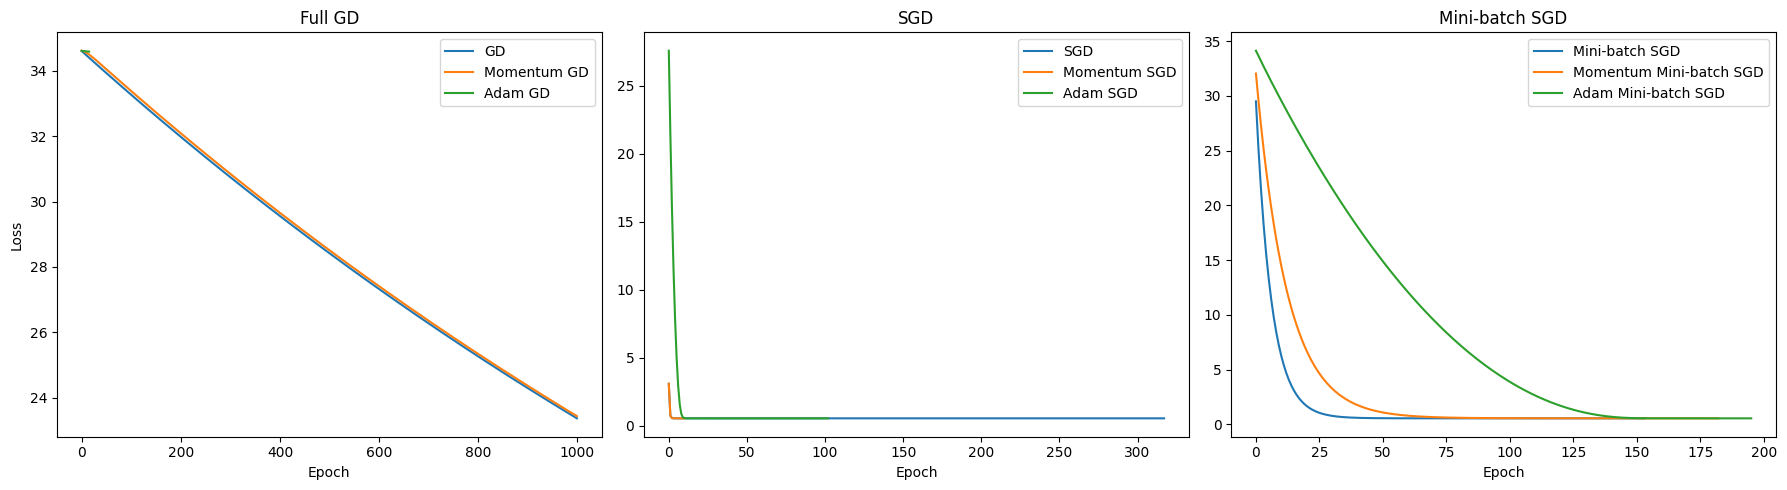

In [154]:
####PLOTTING #####
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

hist_list_1 = [gd_history, gd_m_history, adam_full_history]
labels_1 = ["GD", "Momentum GD", "Adam GD"]
title_1 = "Full GD"

hist_list_2 = [sgd_history, sgd_m_history, adam_sgd_history]
labels_2 = ["SGD", "Momentum SGD", "Adam SGD"]
title_2 = "SGD"
hist_list_3 = [mbatch_history, mb_m_history, adam_mb_history]
labels_3 = ["Mini-batch SGD", "Momentum Mini-batch SGD", "Adam Mini-batch SGD"]
title_3 = "Mini-batch SGD"

# -------- Subplot 1 --------
for hist, label in zip(hist_list_1, labels_1):
    axs[0].plot(hist, label=label)
axs[0].set_title(title_1)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# -------- Subplot 2 --------
for hist, label in zip(hist_list_2, labels_2):
    axs[1].plot(hist, label=label)
axs[1].set_title(title_2)
axs[1].set_xlabel("Epoch")
axs[1].legend()

# -------- Subplot 3 --------
for hist, label in zip(hist_list_3, labels_3):
    axs[2].plot(hist, label=label)
axs[2].set_title(title_3)
axs[2].set_xlabel("Epoch")
axs[2].legend()

plt.tight_layout()
plt.show()